In [29]:
%load_ext autoreload
%autoreload 2

import torch
import experiments.multiclass_classification as exp
from experiments import mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [31]:
batch_size = 128
# LeNet with ReLu
layers = [
    ("conv", (1, 6, 5)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [32]:
torch.manual_seed(42)

trainloader = mnist.fashion_trainloader(batch_size)
testloader = mnist.fashion_testloader(batch_size)
corrupted_testloader = mnist.corrupted_fashion_testloader(batch_size)

In [33]:
from training.pp import PointPredictor

torch.manual_seed(42)
pp = PointPredictor(layers)
#pp.train(15, torch.nn.NLLLoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=1)
#torch.save(pp.state_dict(), "trained_models/mnist/pp.tar")
pp.load_state_dict(torch.load("trained_models/mnist/pp.tar"))
pp.to(device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters


PointPredictor(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

In [34]:
torch.manual_seed(42)
from training.swag import SwagModel
swag_config = {
    "update_every_batches": len(trainloader) // 4,
    "deviation_samples": 20,
    "start_epoch": 10,
    "use_lr_cycles": False,
    "max_lr": 0.01,
    "min_lr": 0.005,
}
swag = SwagModel(layers, swag_config)
#swag.train(15, torch.nn.NLLLoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=1)
#torch.save(swag.state_dict(), "trained_models/mnist/swag.tar")
swag.load_state_dict(torch.load("trained_models/mnist/swag.tar"))
swag.to(device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters


SwagModel(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

In [35]:
from training.ensemble import Ensemble

torch.manual_seed(42)
ensemble = Ensemble([PointPredictor(layers) for _ in range(5)])
#ensemble.train(15, torch.nn.NLLLoss(), sgd(0.01), trainloader, batch_size, device)
#torch.save(ensemble.state_dict(), "trained_models/mnist/ensemble.tar")
ensemble.load_state_dict(torch.load("trained_models/mnist/ensemble.tar"))
ensemble.to(device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
  (12): LogSoftmax(dim=1)
)
44426 trainable parameters
Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_di

Ensemble(
  (models): ModuleList(
    (0): PointPredictor(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Flatten(start_dim=1, end_dim=-1)
        (7): Linear(in_features=256, out_features=120, bias=True)
        (8): ReLU()
        (9): Linear(in_features=120, out_features=84, bias=True)
        (10): ReLU()
        (11): Linear(in_features=84, out_features=10, bias=True)
        (12): LogSoftmax(dim=1)
      )
    )
    (1): PointPredictor(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(6, 16

In [36]:
from training.dropout import MonteCarloDropoutModule

torch.manual_seed(42)
mc_dropout = MonteCarloDropoutModule(layers, 0.1)
#mc_dropout.train(15, torch.nn.NLLLoss(), sgd(0.01), trainloader, batch_size, device)
#torch.save(mc_dropout.state_dict(), "trained_models/mnist/mc_dropout.tar")
mc_dropout.load_state_dict(torch.load("trained_models/mnist/mc_dropout.tar"))
mc_dropout.to(device)

Generated model: Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): FixableDropout()
  (9): ReLU()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): FixableDropout()
  (12): ReLU()
  (13): Linear(in_features=84, out_features=10, bias=True)
  (14): FixableDropout()
  (15): LogSoftmax(dim=1)
)
44426 trainable parameters


MonteCarloDropoutModule(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): FixableDropout()
    (9): ReLU()
    (10): Linear(in_features=120, out_features=84, bias=True)
    (11): FixableDropout()
    (12): ReLU()
    (13): Linear(in_features=84, out_features=10, bias=True)
    (14): FixableDropout()
    (15): LogSoftmax(dim=1)
  )
)

In [37]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", layers)
#bbb.train(15, torch.nn.NLLLoss(reduction="sum"), sgd(0.01), trainloader, batch_size, device)
#torch.save(bbb.state_dict(), "trained_models/mnist/bbb.tar")
bbb.load_state_dict(torch.load("trained_models/mnist/bbb.tar"))
bbb.to(device)

Generated model: Sequential(
  (0): BBBConvolution()
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BBBConvolution()
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): BBBLinear()
  (8): ReLU()
  (9): BBBLinear()
  (10): ReLU()
  (11): BBBLinear()
  (12): LogSoftmax(dim=1)
)
88852 trainable parameters


BBBModel(
  (model): Sequential(
    (0): BBBConvolution()
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BBBConvolution()
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): BBBLinear()
    (8): ReLU()
    (9): BBBLinear()
    (10): ReLU()
    (11): BBBLinear()
    (12): LogSoftmax(dim=1)
  )
)

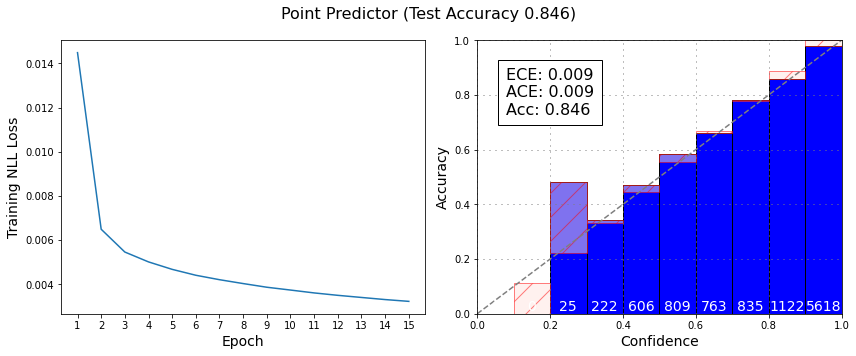

In [38]:
exp.eval_model("Point Predictor", pp.infer, pp.all_losses(), 1, testloader, device).savefig("figures/fmnist_pp_15e.png")

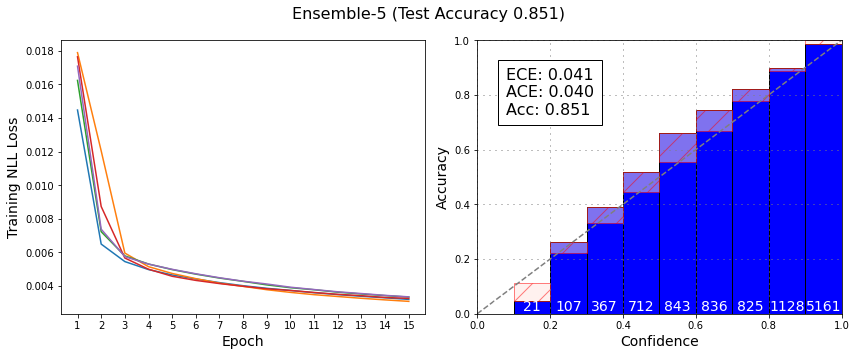

In [48]:
exp.eval_model("Ensemble-5", ensemble.infer, ensemble.all_losses(), 1, testloader, device).savefig("figures/fmnist_ensemble5_15e.png")

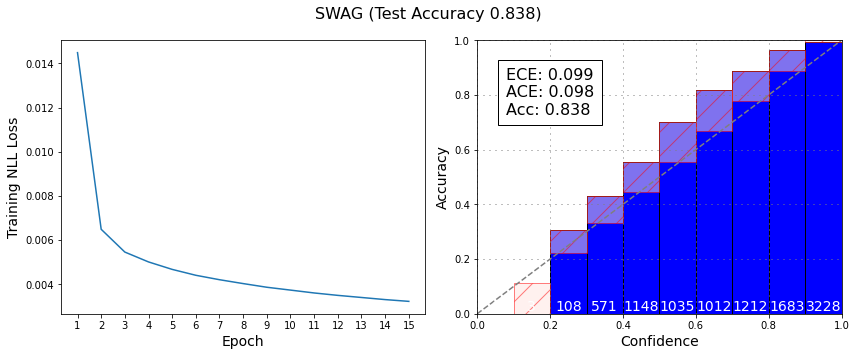

In [ ]:
exp.eval_model("SWAG", swag.infer, swag.all_losses(), 100, testloader, device).savefig("figures/fmnist_swag20k_15e.png")

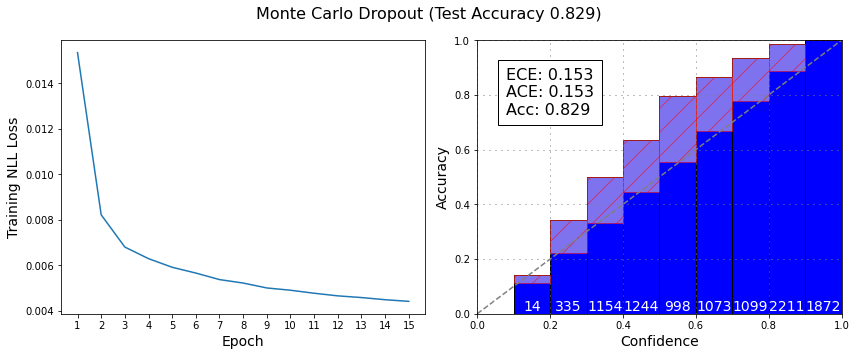

In [ ]:
exp.eval_model("Monte Carlo Dropout", mc_dropout.infer, mc_dropout.all_losses(), 100, testloader, device).savefig("figures/fmnist_mcd0.1p_15e.png")

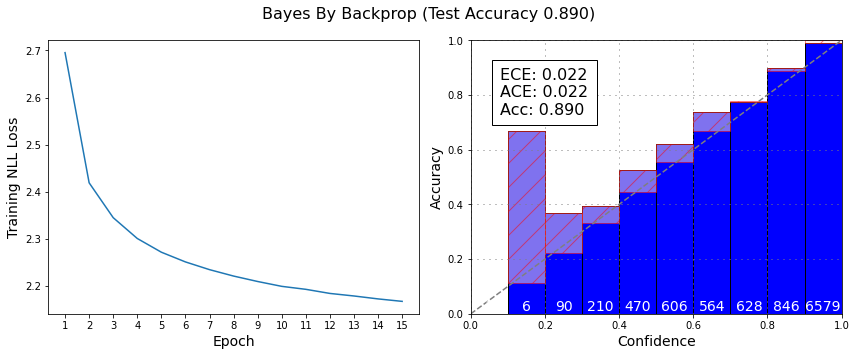

In [ ]:
exp.eval_model("Bayes By Backprop", lambda x, s: bbb.infer(x, s), bbb.all_losses(), 100, testloader, device).savefig("figures/fmnist_bbb_15e.png")

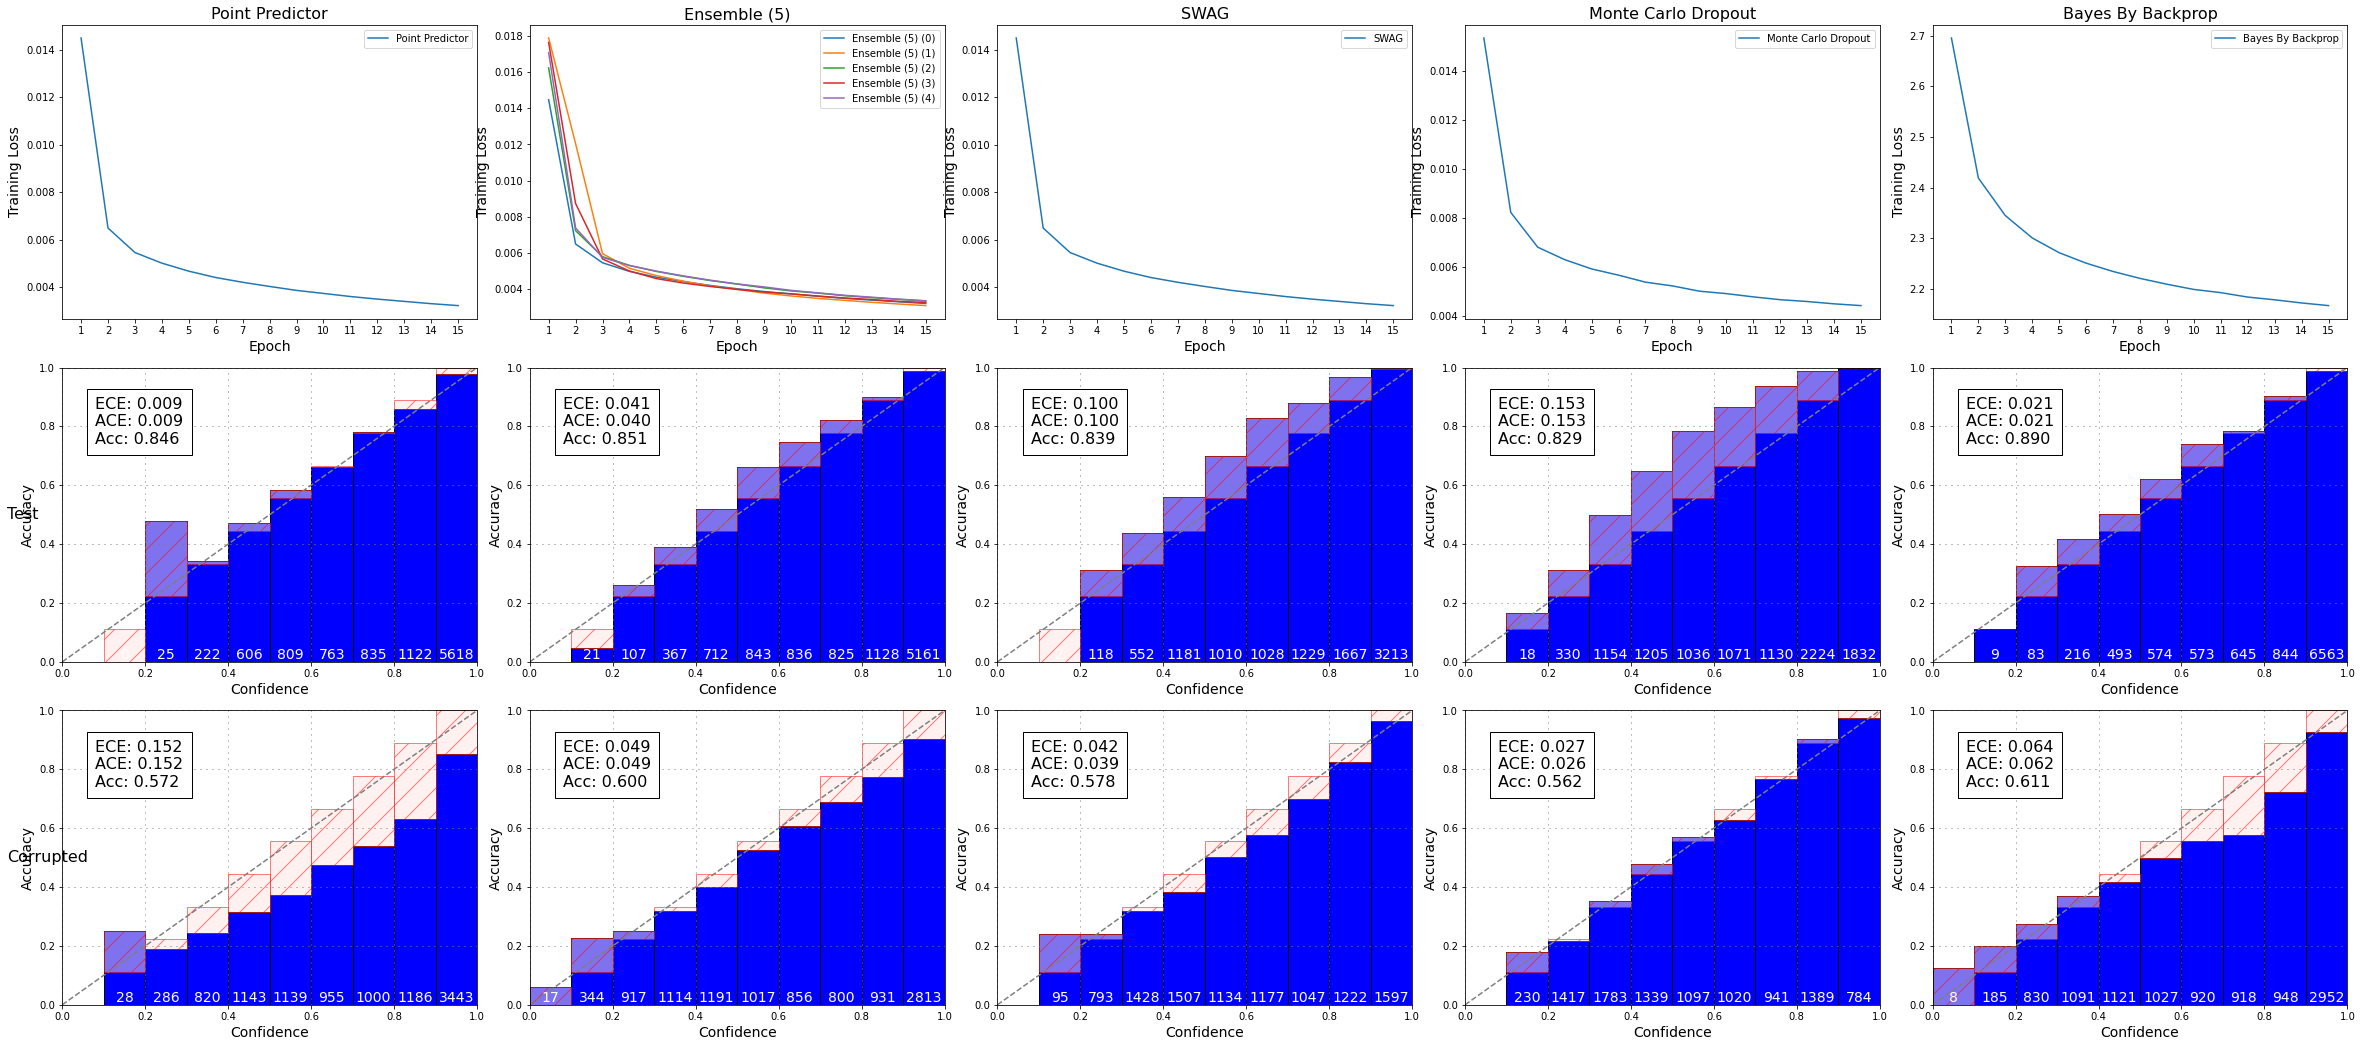

In [ ]:
exp.eval_multiple(
    [
        ("Point Predictor", pp.infer, pp.all_losses(), [], 1),
        ("Ensemble (5)", ensemble.infer, ensemble.all_losses(), [], 1),
        ("SWAG", swag.infer, swag.all_losses(), [], 100),
        ("Monte Carlo Dropout", mc_dropout.infer, mc_dropout.all_losses(), [], 100),
        ("Bayes By Backprop", bbb.infer, bbb.all_losses(), [], 100)
    ],
    [
        ("Test", testloader),
        ("Corrupted", corrupted_testloader)
    ],
    device
).savefig("figures/mnist_all.png")